## Installing Packages

In this section I install the packages I will be needing. I install arcgis for geocoding as well as Geoff Boeing's osmnx package, which I will use later on.

In [48]:
!pip install --upgrade geopandas mapclassify folium


In [49]:
from IPython.display import Image
import matplotlib.pyplot as plt

In [50]:
import geopandas as gpd
import pandas as pd
import mapclassify
import folium


In [51]:
!pip install census contextily adjustText 

In [52]:
import contextily as ctx 
from census import Census
from adjustText import adjust_text
from folium import plugins

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

In [54]:
import geopy.distance as distance
import math


## Reading in Data

In this section I aggregate and map pedestrian incidents by Neighborhood Tabulation Area (NTA), a common unit of analysis for New York City. The aim of this section is to get a preliminary understanding of which New York neighborhoods are the most dangerous for pedestrians.

In [55]:
crashes_gdf = pd.read_csv('geocoded_crashes.csv')

/tmp/ipykernel_257/148663088.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  crashes_gdf = pd.read_csv('geocoded_crashes.csv')


In [56]:
crashes_gdf = gpd.GeoDataFrame(
        crashes_gdf, geometry=gpd.points_from_xy(crashes_gdf['LONGITUDE'], crashes_gdf['LATITUDE']), crs = 4326)

In [57]:
#read in nta geometry

nyc_nta = gpd.read_file('https://data.cityofnewyork.us/resource/9nt8-h7nd.geojson')

In [58]:
crashes_gdf.dtypes

Unnamed: 0                          int64
CRASH DATE                         object
CRASH TIME                         object
BOROUGH                            object
ZIP CODE                           object
LATITUDE                          float64
LONGITUDE                         float64
LOCATION                           object
ON STREET NAME                     object
CROSS STREET NAME                  object
OFF STREET NAME                    object
NUMBER OF PERSONS INJURED         float64
NUMBER OF PERSONS KILLED          float64
NUMBER OF PEDESTRIANS INJURED       int64
NUMBER OF PEDESTRIANS KILLED        int64
NUMBER OF CYCLIST INJURED           int64
NUMBER OF CYCLIST KILLED            int64
NUMBER OF MOTORIST INJURED          int64
NUMBER OF MOTORIST KILLED           int64
CONTRIBUTING FACTOR VEHICLE 1      object
CONTRIBUTING FACTOR VEHICLE 2      object
CONTRIBUTING FACTOR VEHICLE 3      object
CONTRIBUTING FACTOR VEHICLE 4      object
CONTRIBUTING FACTOR VEHICLE 5     

In [59]:
nyc = gpd.read_file('Borough Boundaries.geojson')

In [60]:
#project to wgs84
nyc_wgs = nyc.to_crs(epsg = 4326)

In [61]:
len(crashes_gdf)

110916

In [62]:
crashes_gdf = crashes_gdf.clip(nyc_wgs)

In [63]:
nta_wgs = nyc_nta.to_crs(epsg = 4326)

## Drawing a simple hexbin map

The methodology for calculating the Hexbin scale comes from [Thiago Carvalho](https://python.plainenglish.io/mapping-with-pythons-geopandas-2869bb758b08).

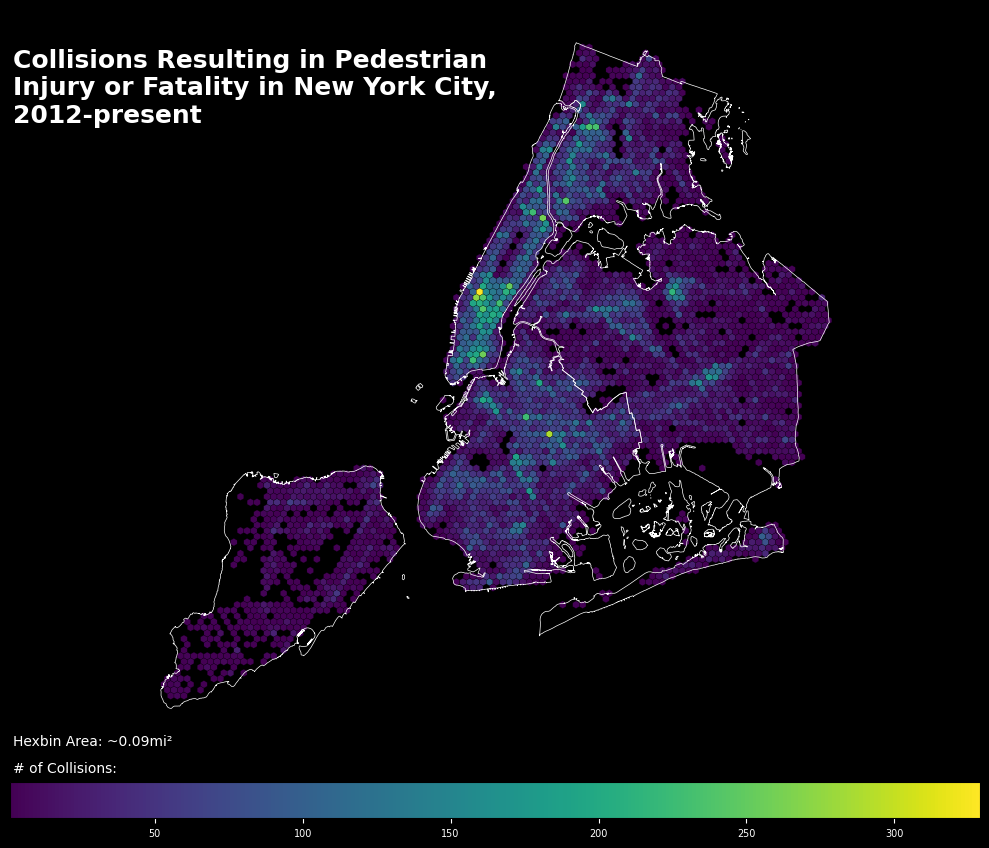

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))

hb = ax.hexbin(
    crashes_gdf['LONGITUDE'], 
    crashes_gdf['LATITUDE'],
    mincnt =1, #don't show hexbins with zero points
    gridsize=100,
    alpha = 1,
    cmap='viridis',
    edgecolors = 'black',
    linewidths = 0.15,
    zorder = 1)


fig.patch.set_facecolor('black')

nyc_wgs.plot(ax = ax, facecolor = 'none', edgecolor = 'white', linewidth = .5, zorder = 2)

#get scale

ex = [plt.xlim()[0], plt.xlim()[1], 
      plt.ylim()[0], plt.ylim()[1]]

coords_1 = (ex[2], ex[0])
coords_2 = (ex[2], ex[1])
d2 = distance.geodesic(coords_1, coords_2).m/100
a = d2/ math.sqrt(3)
A = (3/2 * math.sqrt(3) * pow(a,2))/2589988.1103

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.4)

cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")
cbar.ax.tick_params(labelsize=7, color='white', labelcolor='white')

scale_txt = 'Hexbin Area: ~'+ '%.2f'%A +'mi²'
plt.text(2, 2, scale_txt, color='white', fontsize=10)
plt.text(2, 1.25, '# of Collisions:', color='white', fontsize=10)

title = 'Collisions Resulting in Pedestrian\n\
Injury or Fatality in New York City,\n2012-present'
plt.text(2, 19, title, color = 'white', fontsize = 18, fontweight = 'bold')

ax.axis("off")
plt.tight_layout()
plt.show()
fig.savefig("collisions_hexbin.jpeg", dpi = 250)

## Preparing the Data for Choropleth Maps

In [80]:
nta_wgs.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ..."
1,28854314.2319,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0270184,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((-73.96176 40.72523, -73.96154 ..."
2,15208960.6551,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2802623,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ..."
3,52266211.1496,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.7728149,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ..."
4,9982321.61811,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.5049112,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ..."


In [81]:
#look at dtypes
nta_wgs.dtypes

shape_area      object
ntaname         object
cdtaname        object
shape_leng      object
boroname        object
ntatype         object
nta2020         object
borocode        object
countyfips      object
ntaabbrev       object
cdta2020        object
geometry      geometry
dtype: object

In [82]:
#convert shape area to float
nta_wgs['shape_area'] = nta_wgs['shape_area'].astype(float)

In [83]:
#get nta area in square miles
nta_wgs['area_sq_mi'] = nta_wgs['shape_area']/27878400

In [84]:
nta_wgs.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry,area_sq_mi
0,3.532121e+07,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ...",1.266974
1,2.885431e+07,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0270184,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((-73.96176 40.72523, -73.96154 ...",1.035006
2,1.520896e+07,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2802623,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ...",0.545546
3,5.226621e+07,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.7728149,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ...",1.874792
4,9.982322e+06,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.5049112,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ...",0.358067


In [85]:
#introduce variable for counting crashes

crashes_gdf['crash'] = 1


In [86]:
#spatial join nta's to crashes

nta_joined = nta_wgs.sjoin(crashes_gdf)

In [87]:
nta_joined.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,...,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,ESRI_Match_Score,ESRI_Match_Type,crash
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,...,NaN,4512847,Box Truck,NaN,NaN,NaN,NaN,NaN,NaN,1
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,...,NaN,4269596,Sedan,NaN,NaN,NaN,NaN,NaN,NaN,1
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,...,NaN,3459451,Pick-up Truck,NaN,NaN,NaN,NaN,NaN,NaN,1
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,...,NaN,4252388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
0,35321206.58,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,...,NaN,4589679,Bike,NaN,NaN,NaN,NaN,NaN,NaN,1


In [88]:
#aggregate and get crash count, fatalities count and injured count for each nta

nta_crashes_agg = pd.DataFrame(nta_joined.groupby(by = 'ntaname').aggregate({'crash':'sum', 'NUMBER OF PEDESTRIANS KILLED':'sum', 'NUMBER OF PEDESTRIANS INJURED': 'sum'}))

nta_crashes_agg_gdf = nta_wgs.merge(nta_crashes_agg, how = 'left', on = 'ntaname')

nta_crashes_agg_gdf.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry,area_sq_mi,crash,NUMBER OF PEDESTRIANS KILLED,NUMBER OF PEDESTRIANS INJURED
0,3.532121e+07,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ...",1.266974,338.0,4.0,342.0
1,2.885431e+07,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0270184,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((-73.96176 40.72523, -73.96154 ...",1.035006,753.0,7.0,785.0
2,1.520896e+07,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2802623,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ...",0.545546,702.0,8.0,730.0
3,5.226621e+07,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.7728149,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ...",1.874792,838.0,19.0,849.0
4,9.982322e+06,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.5049112,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ...",0.358067,249.0,1.0,258.0


In [89]:
nta_crashes_agg_gdf['crashes_per_sq_mi'] = nta_crashes_agg_gdf['crash']/nta_crashes_agg_gdf['area_sq_mi']
nta_crashes_agg_gdf['fatalities_per_sq_mi'] = nta_crashes_agg_gdf['NUMBER OF PEDESTRIANS KILLED']/nta_crashes_agg_gdf['area_sq_mi']
nta_crashes_agg_gdf['injuries_per_sq_mi'] = nta_crashes_agg_gdf['NUMBER OF PEDESTRIANS INJURED']/nta_crashes_agg_gdf['area_sq_mi']

In [90]:
nta_crashes_agg_gdf.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ntatype,nta2020,borocode,countyfips,ntaabbrev,cdta2020,geometry,area_sq_mi,crash,NUMBER OF PEDESTRIANS KILLED,NUMBER OF PEDESTRIANS INJURED,crashes_per_sq_mi,fatalities_per_sq_mi,injuries_per_sq_mi
0,3.532121e+07,Greenpoint,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.5661127,Brooklyn,0,BK0101,3,047,Grnpt,BK01,"MULTIPOLYGON (((-73.93213 40.72816, -73.93238 ...",1.266974,338.0,4.0,342.0,266.777387,3.157129,269.934516
1,2.885431e+07,Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.0270184,Brooklyn,0,BK0102,3,047,Wllmsbrg,BK01,"MULTIPOLYGON (((-73.96176 40.72523, -73.96154 ...",1.035006,753.0,7.0,785.0,727.531940,6.763245,758.449632
2,1.520896e+07,South Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.2802623,Brooklyn,0,BK0103,3,047,SWllmsbrg,BK01,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ...",0.545546,702.0,8.0,730.0,1286.783314,14.664197,1338.108005
3,5.226621e+07,East Williamsburg,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.7728149,Brooklyn,0,BK0104,3,047,EWllmsbrg,BK01,"MULTIPOLYGON (((-73.92406 40.71411, -73.92404 ...",1.874792,838.0,19.0,849.0,446.982834,10.134456,452.850151
4,9.982322e+06,Brooklyn Heights,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.5049112,Brooklyn,0,BK0201,3,047,BkHts,BK02,"MULTIPOLYGON (((-73.99236 40.68969, -73.99436 ...",0.358067,249.0,1.0,258.0,695.401517,2.792777,720.536512


## Drawing choropleth maps by NTA

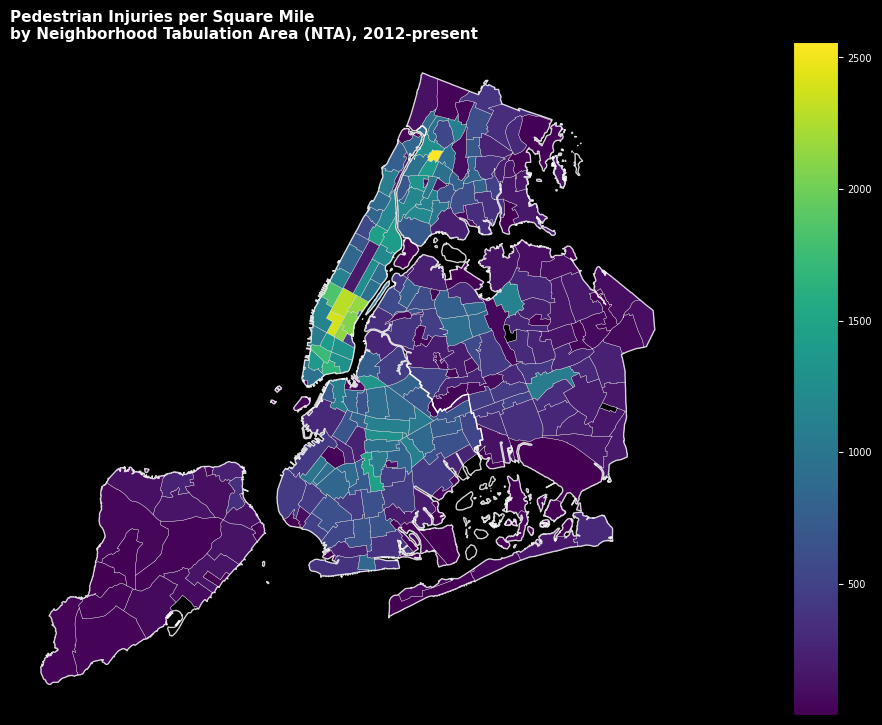

In [100]:
fig, ax = plt.subplots(figsize = (10,10))


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0)
cmap = plt.cm.viridis

fig.patch.set_facecolor('black')


nta_crashes_agg_gdf.plot(column = 'injuries_per_sq_mi', legend = True, alpha = 1, cax = cax, cmap = cmap, ax = ax, zorder =1)


cax.tick_params(labelsize=7, color='white', labelcolor='white')

nta_wgs.plot(facecolor = 'none', edgecolor = 'white', linewidth = .2, ax = ax, zorder = 2)
nyc_wgs.plot(ax = ax, facecolor = 'none', edgecolor = 'white', alpha = .75, linewidth = 1, zorder = 3)

title = 'Pedestrian Injuries per Square Mile\n\
by Neighborhood Tabulation Area (NTA), 2012-present'
ax.set_title(title, fontsize=11, pad=0, loc = 'left', color = 'white', fontweight = 'bold')



ax.axis("off")

plt.tight_layout()
fig.savefig("injuries_choropleth.jpeg", dpi = 300)


(-74.28337047814922, -73.67222994821337, 40.475164048167294, 40.93650271594721)

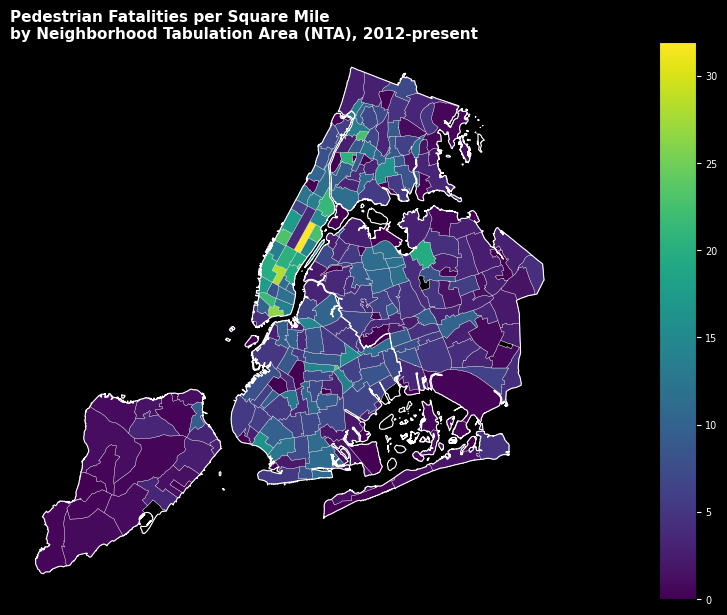

In [102]:
fig, ax = plt.subplots(figsize = (10,10))


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0)
cmap = plt.cm.viridis

fig.patch.set_facecolor('black')


nta_crashes_agg_gdf.plot(column = 'fatalities_per_sq_mi', legend = True, alpha = 1, cax = cax, cmap = cmap, ax = ax, zorder =1)


cax.tick_params(labelsize=7, color='white', labelcolor='white')

nta_wgs.plot(facecolor = 'none', edgecolor = 'white', linewidth = .2, ax = ax, zorder = 2)
nyc_wgs.plot(ax = ax, facecolor = 'none', edgecolor = 'white', linewidth = .8, zorder = 3)

title = 'Pedestrian Fatalities per Square Mile\n\
by Neighborhood Tabulation Area (NTA), 2012-present'
ax.set_title(title, fontsize=11, pad=0, loc = 'left', color = 'white', fontweight = 'bold')



ax.axis("off")




## Getting and charting most dangerous neighborhoods for pedestrians

In [93]:
nta_crashes_agg_gdf['nta_with_boro'] = nta_crashes_agg_gdf['ntaname'] + ',' + " " + nta_crashes_agg_gdf['boroname']

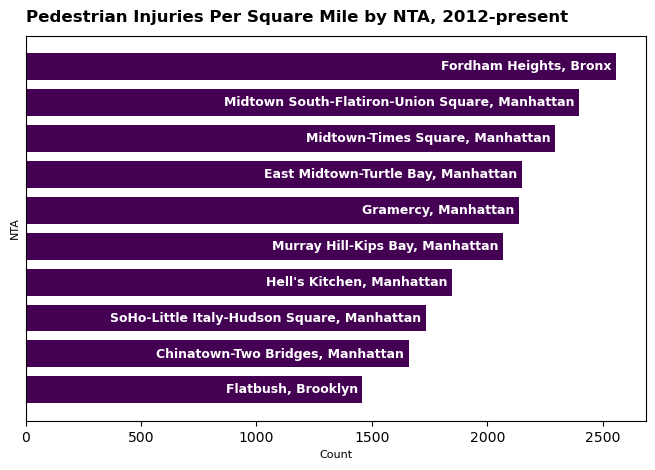

In [94]:

df = nta_crashes_agg_gdf.sort_values(by='injuries_per_sq_mi', ascending=False).head(10)

df = df.reset_index()
fig, ax = plt.subplots(figsize=(8,5))

ax.barh(df['injuries_per_sq_mi'].index[::-1], df['injuries_per_sq_mi'], height=0.75, color="#440154")

label = 'Pedestrian Injuries Per Square Mile by NTA, 2012-present'
plt.yticks([])
plt.title(label, fontsize=12, pad=10, x=0, ha = 'left',fontweight = 'bold')
plt.xlabel('Count', fontsize=8)
plt.ylabel('NTA', fontsize=8)

for i, row in df.iterrows():
    ax.text(row['injuries_per_sq_mi'] - 20, 9-i, str(row['nta_with_boro']), color='white', fontweight='bold', fontsize=9, ha='right', va='center')


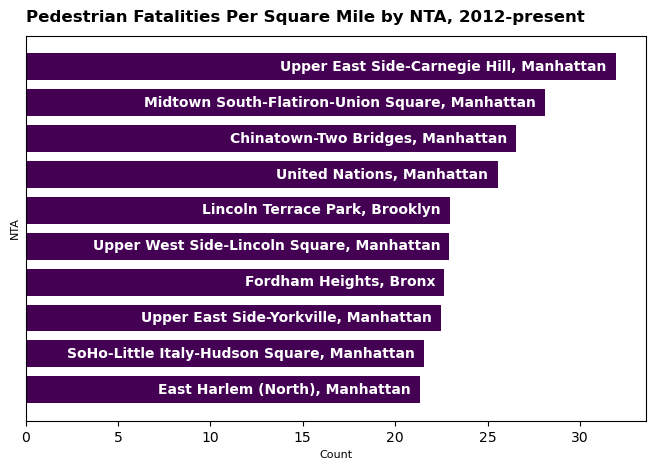

In [95]:
df = nta_crashes_agg_gdf.sort_values(by='fatalities_per_sq_mi', ascending=False).head(10)

df = df.reset_index()
fig, ax = plt.subplots(figsize=(8,5))

ax.barh(df['fatalities_per_sq_mi'].index[::-1], df['fatalities_per_sq_mi'], height=0.75, color="#440154")

label = 'Pedestrian Fatalities Per Square Mile by NTA, 2012-present'
plt.yticks([])
plt.title(label, fontsize=12, pad=10, x=0, fontweight = 'bold', ha = 'left')
plt.xlabel('Count', fontsize=8)
plt.ylabel('NTA', fontsize=8)

for i, row in df.iterrows():
    ax.text(row['fatalities_per_sq_mi'] -.5, 9-i, str(row['nta_with_boro']), color='white', fontweight='bold', fontsize=10, ha='right', va='center')